In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
!pip install xgboost==1.3.3

     |████████████████████████████████| 157.5MB 99kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import xgboost as xgb

print(xgb.__version__)

1.3.3


In [ ]:
combined_data = pd.read_csv('cleaned_data.csv')

In [ ]:
combined_data.head()

,T,TM,Tm,H,PP,VV,V,VM,PM_2_5
0,23.4,30.3,19.0,59.0,0.0,6.3,4.3,5.4,284.795833
1,22.4,30.3,16.9,57.0,0.0,6.9,3.3,7.6,239.695455
2,24.0,31.8,16.9,51.0,0.0,6.9,2.8,5.4,182.187500
3,22.8,30.2,17.6,55.0,0.0,7.7,3.7,7.6,264.064286
4,23.1,30.6,17.4,46.0,0.0,6.9,3.3,5.4,223.208333


In [ ]:
combined_data.columns

Index(['T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'PM_2_5'], dtype='object')

In [ ]:
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

## XGBOOST REGRESSOR

In [ ]:
# from xgboost import XGBRegressor
# xgb = XGBRegressor()
# xgb.fit(X_train, y_train)

[13:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,gpu_id=0,tree_method = "gpu_hist",)

In [ ]:
xg_reg.fit(X_train,y_train)

[15:10:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=2, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [ ]:
preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 91.643061


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'tree_method':'gpu_hist','gpu_id':0}

In [ ]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=43)

[15:11:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,132.035271,3.989803,132.281543,8.764281
1,121.960365,3.880309,122.760188,9.324425
2,113.786008,3.642514,114.866974,9.420111
3,105.816325,3.559397,107.517278,9.482399
4,98.526675,3.457820,100.825528,9.779166


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

49    62.639528
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[15:11:15] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


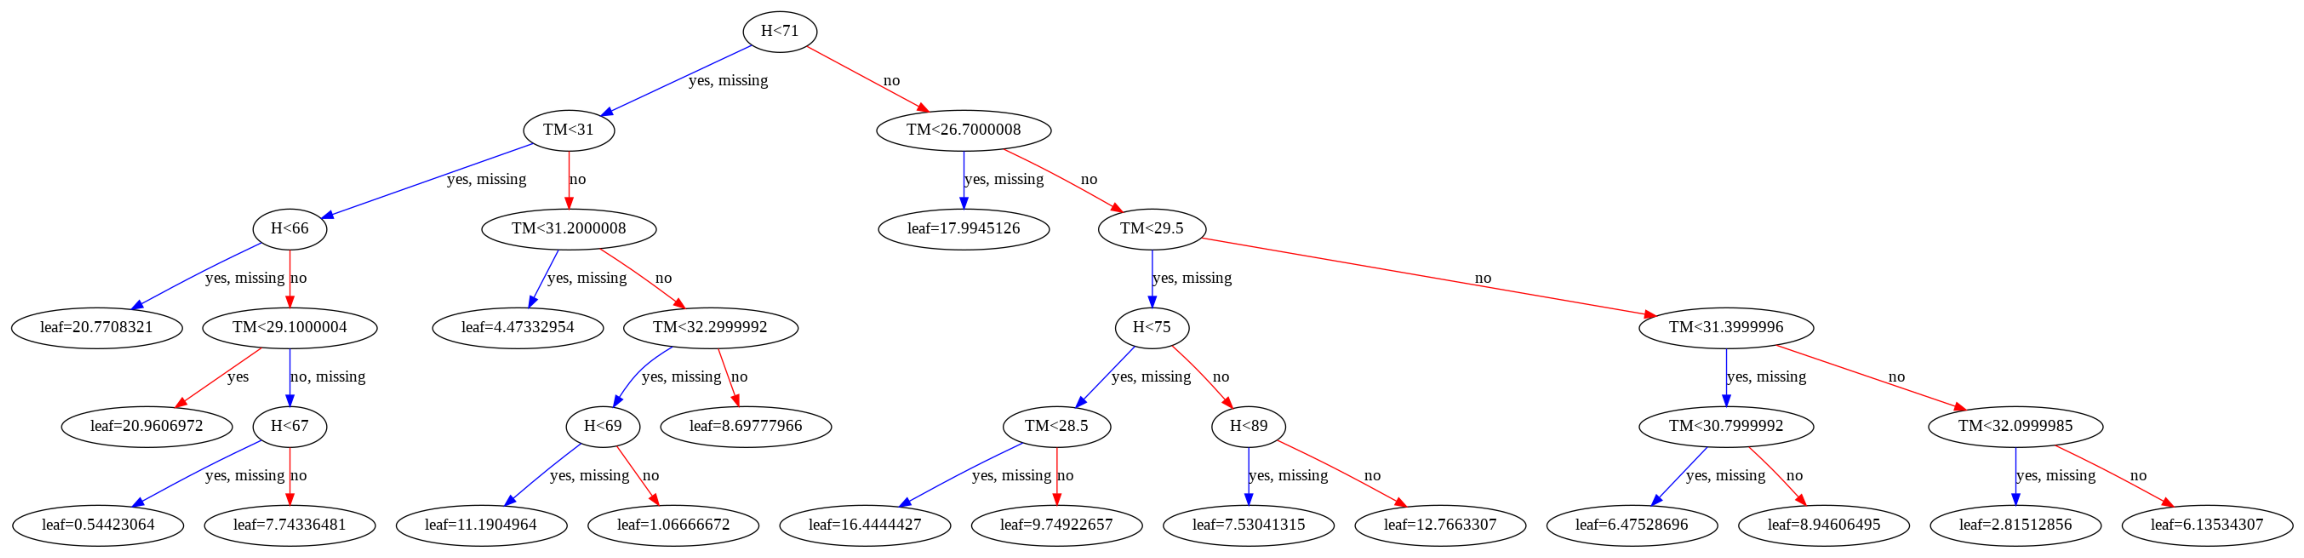

<Figure size 3600x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
plt.show()
plt.savefig('treeplot')

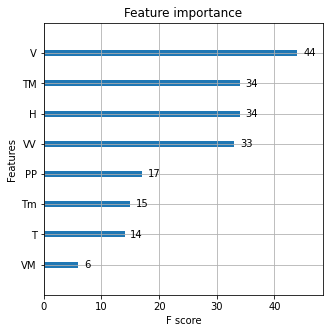

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

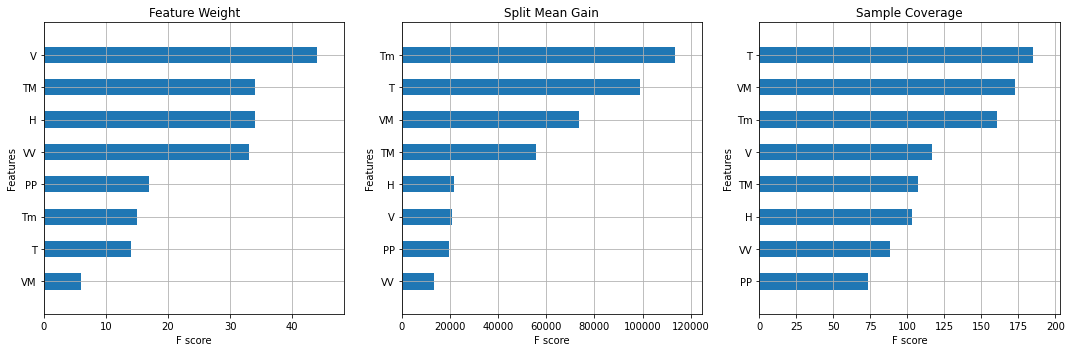

<Figure size 360x360 with 0 Axes>

In [ ]:
# store the winning model in a new variable
_
# saving the feature names to the model

# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xg_reg, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xg_reg,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xg_reg,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()
plt.savefig('metrics')

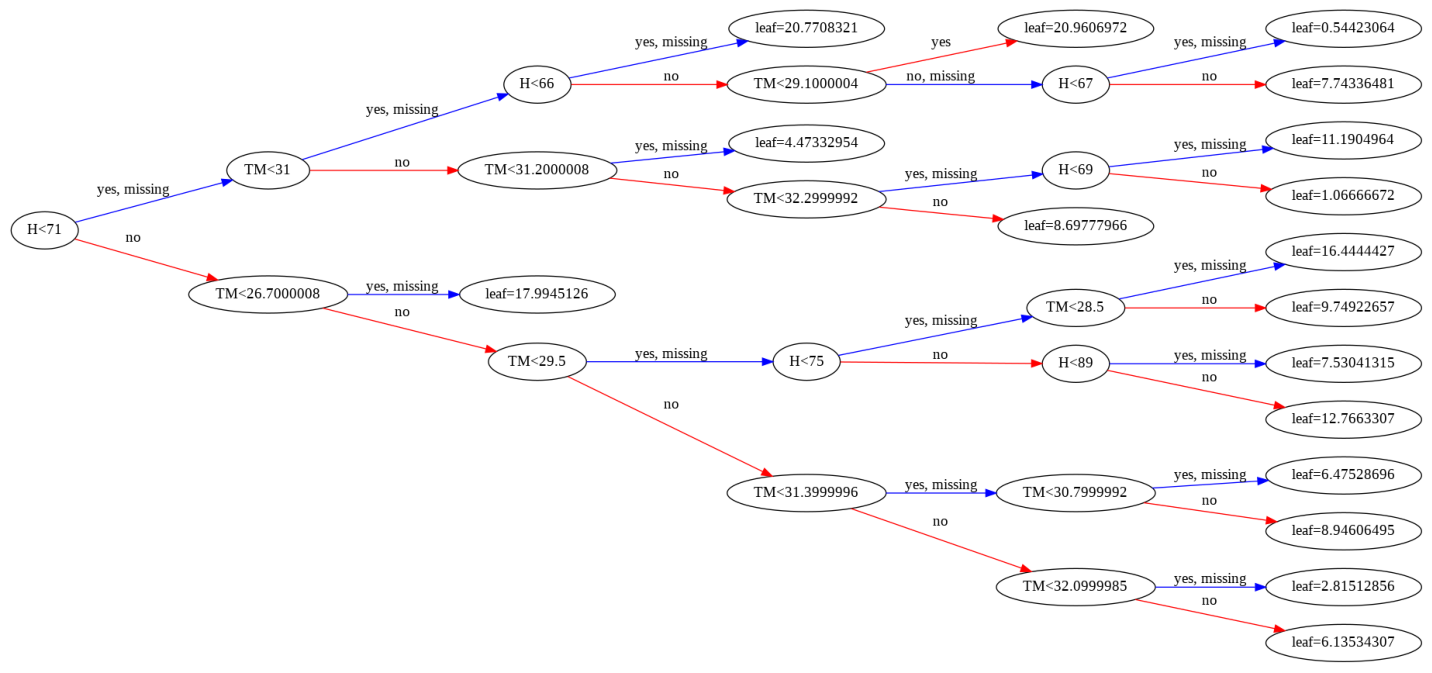

<Figure size 360x360 with 0 Axes>

In [ ]:
# Create the feature importances plot
fig, ax = plt.subplots(figsize=(20,20))
# plot a decision tree from the booster
xgb.plot_tree(booster=xg_reg, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()
plt.savefig('treeplot_horizontal')

In [ ]:
f'Coefficient of determination R^2 on train set {xgb.score(X_train, y_train)}'
# must be close to 1, 1 is perfect fit

AttributeError: ignored

In [ ]:
f'Coefficient of determination R^2 on test set {xgb.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.36292781401846796'

### OVERFIT MODEL

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb, X, y, cv = 3)

[13:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
score.mean()

0.29975471126334907

In [ ]:
pred = xgb.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


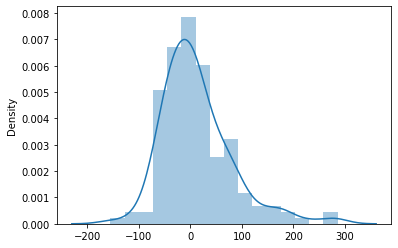

In [ ]:
sns.distplot(y_test - pred)

#### HYPERPARAMETER TUNING

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
subsample = [0.7, 0.6, 0.8]
min_child_weight = list(range(3, 8))
objective = ['reg:squarederror']
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'min_child_weight': min_child_weight,
    'objective': objective
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(xgb, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=100, random_state=43, n_jobs=-1, verbose=True)
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6],
                                   

In [ ]:
search.best_params_

{'learning_rate': 0.05,
 'max_depth': 20,
 'min_child_weight': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [ ]:
search.best_score_

-5025.3837576089745

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


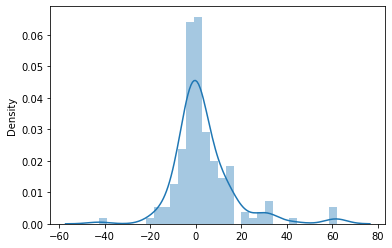

In [ ]:
pred = search.predict(X_test)
sns.distplot(y_test-pred)

In [ ]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 8.277064511406477
Mean Sq Error: 192.08441507308692
Root Mean Error: 13.859452192387941


In [ ]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
xgb.get_booster().feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']

In [ ]:
final_features=[25,34,14,23,45,56,1,0]
x=np.asarray(final_features).reshape(1,-1)
xgb.predict(x)

array([81.23996], dtype=float32)

In [ ]:
import pickle
pickle.dump(search, open('xgb_model2.pkl', 'wb'))

In [ ]:
import pickle
model = pickle.load(open('xgb_model.pkl', "rb"))
pred=model.predict([[25,34,14,23,45,56,1,0]])
print(pred)

XGBoostError: ignored